# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di
tqdm.pandas()

## Memuat data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.shape

(47331, 17)

Data terdiri atas 17 kolom dan 47331 baris data. Data yang akan dieksplorasi berkaitan dengan ulasan pelanggan terhadap film. Data ini disimpan dalam kolom 'review'. 

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

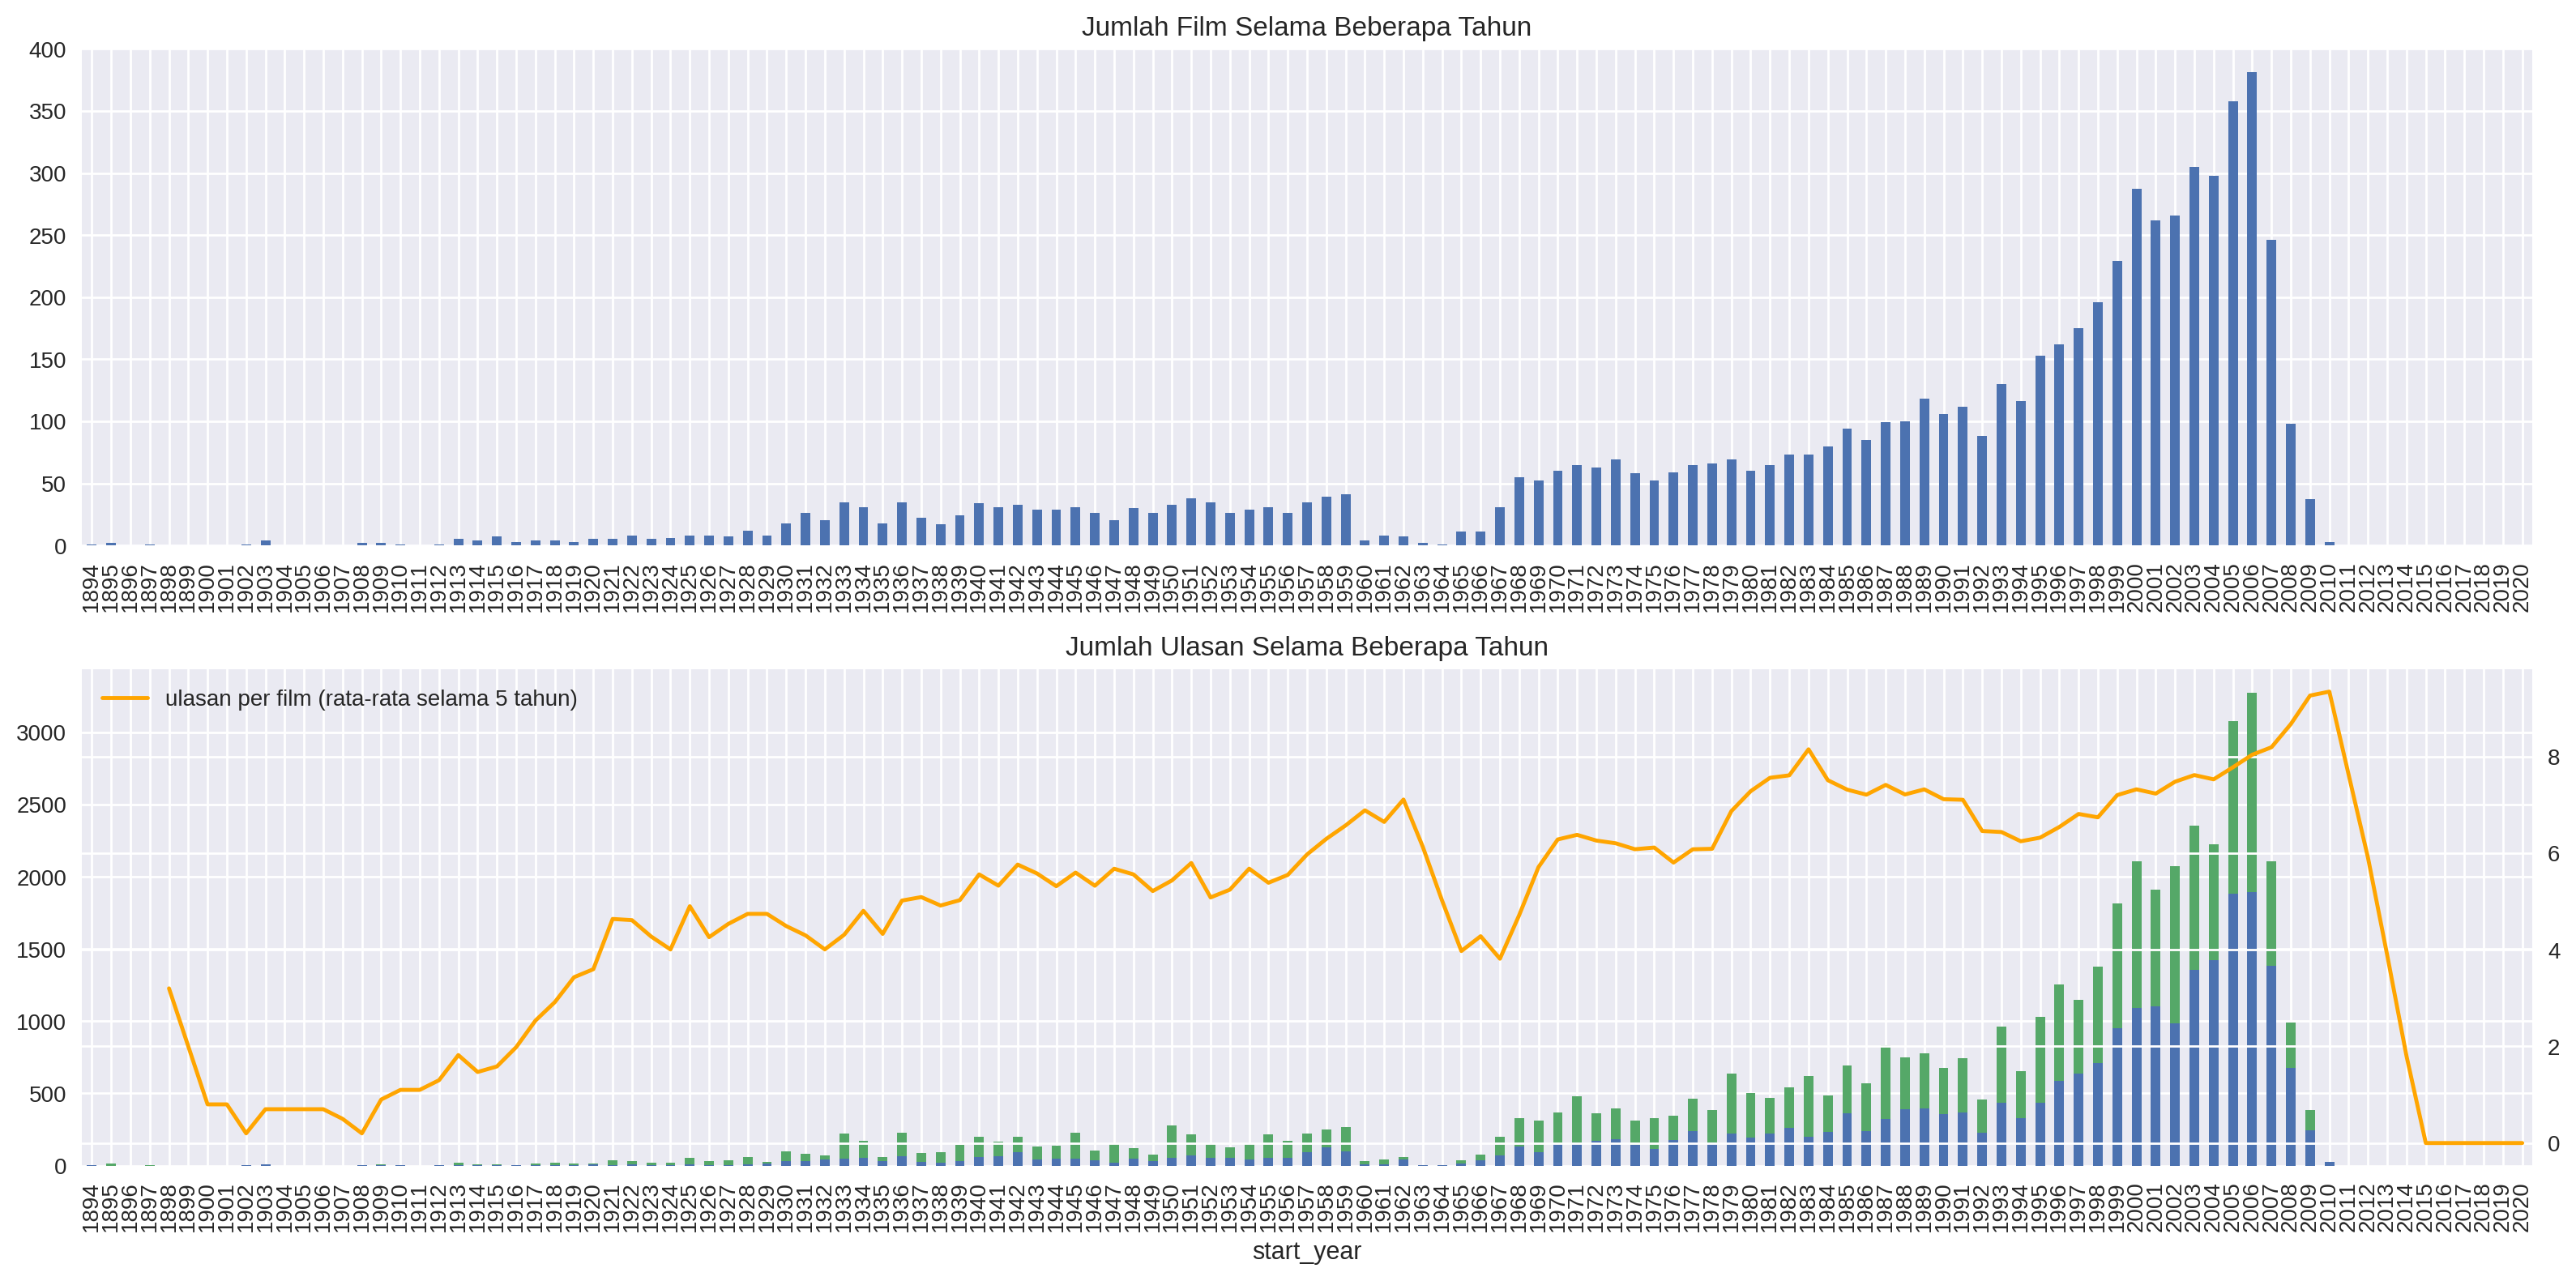

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Berdasarkan grafik, terlihat bahwa jumlah ulasan memiliki pola yang sama dengan jumlah film yang dirilis. Ulasan negatif umumnya menjadi mayoritas. Jumlah film yang dirilis memiliki peningkatan yang konstan dan mengalami puncak pada tahun 2006, sebelum akhirnya mengalami penurunan tajam di tahun-tahun berikutnya. 

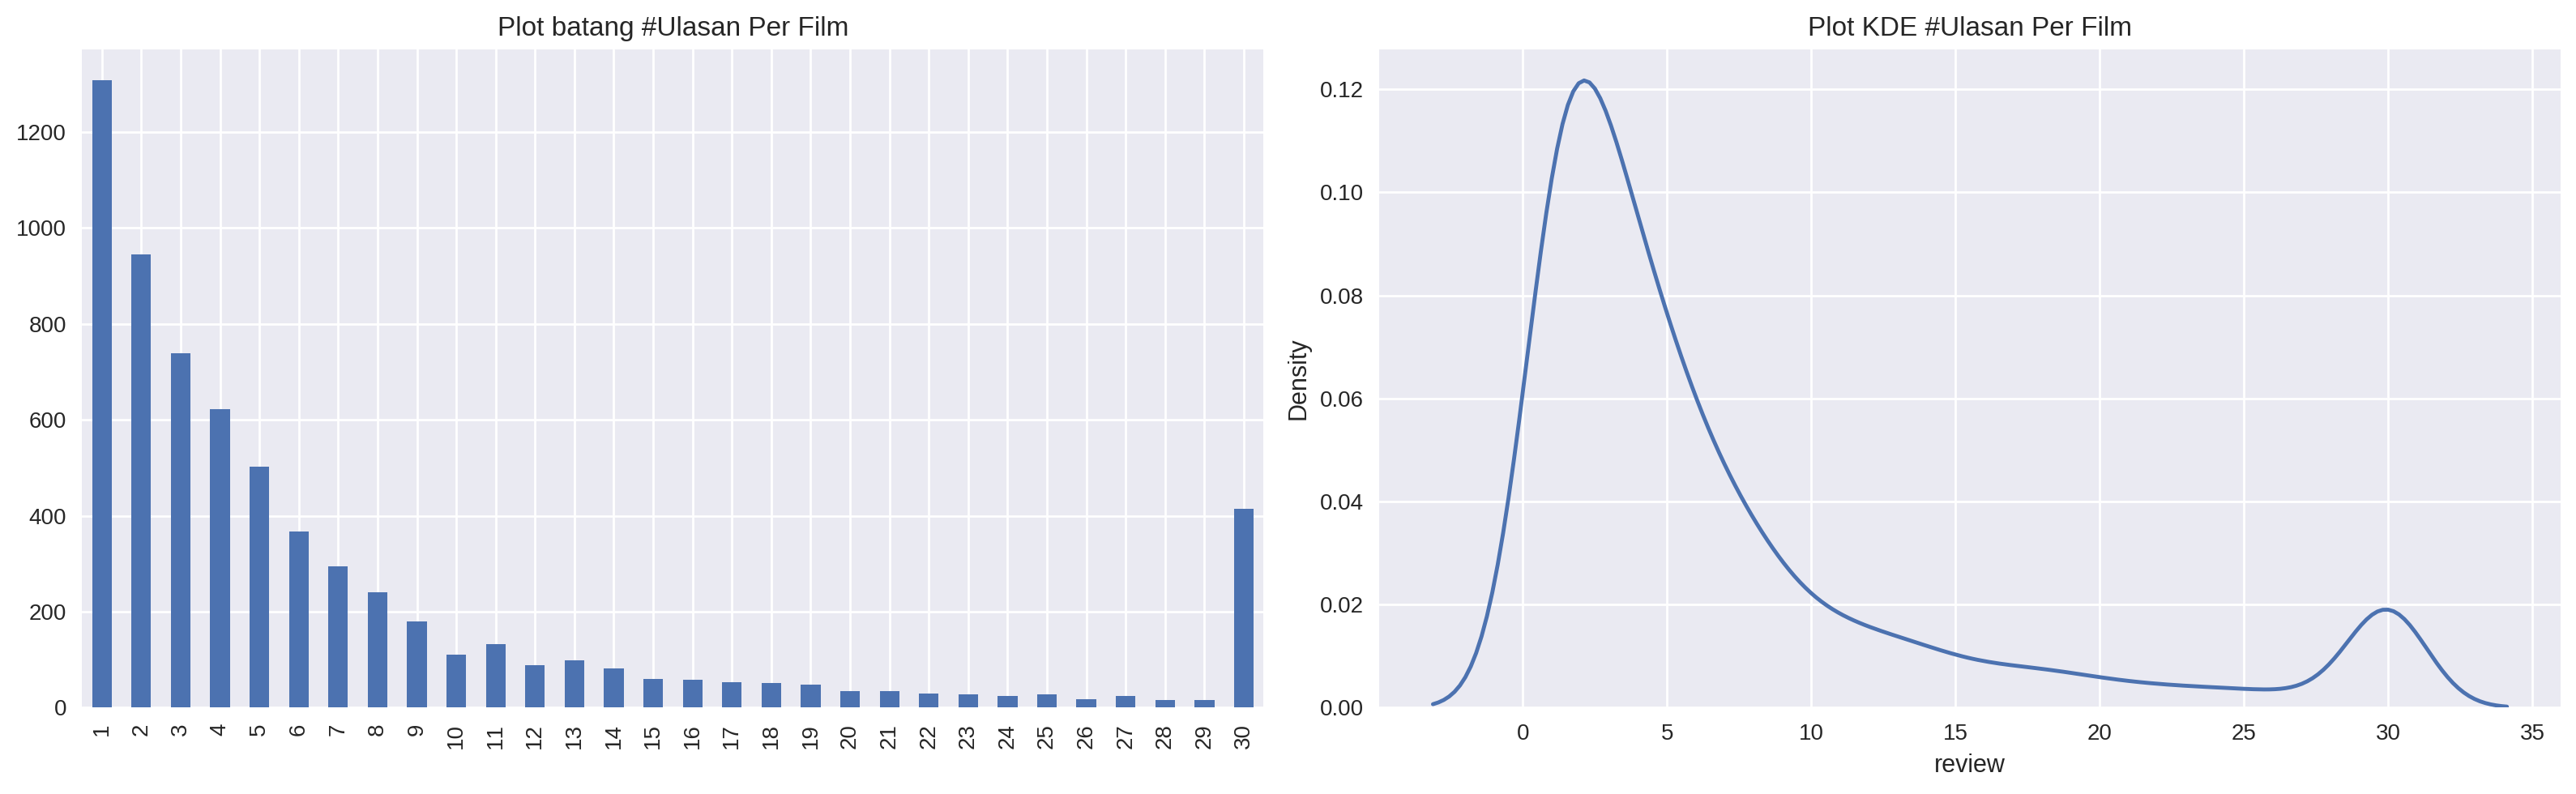

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Plot jumlah ulasan per film menunjukkan bahwa sebagian besar film hanya memiliki satu ulasan dan jumlah film dengan lebih dari satu ulasan menurun seiring peningkatan jumlah ulasan film. Berat kelas target memiliki berat yang relatif seimbang. 

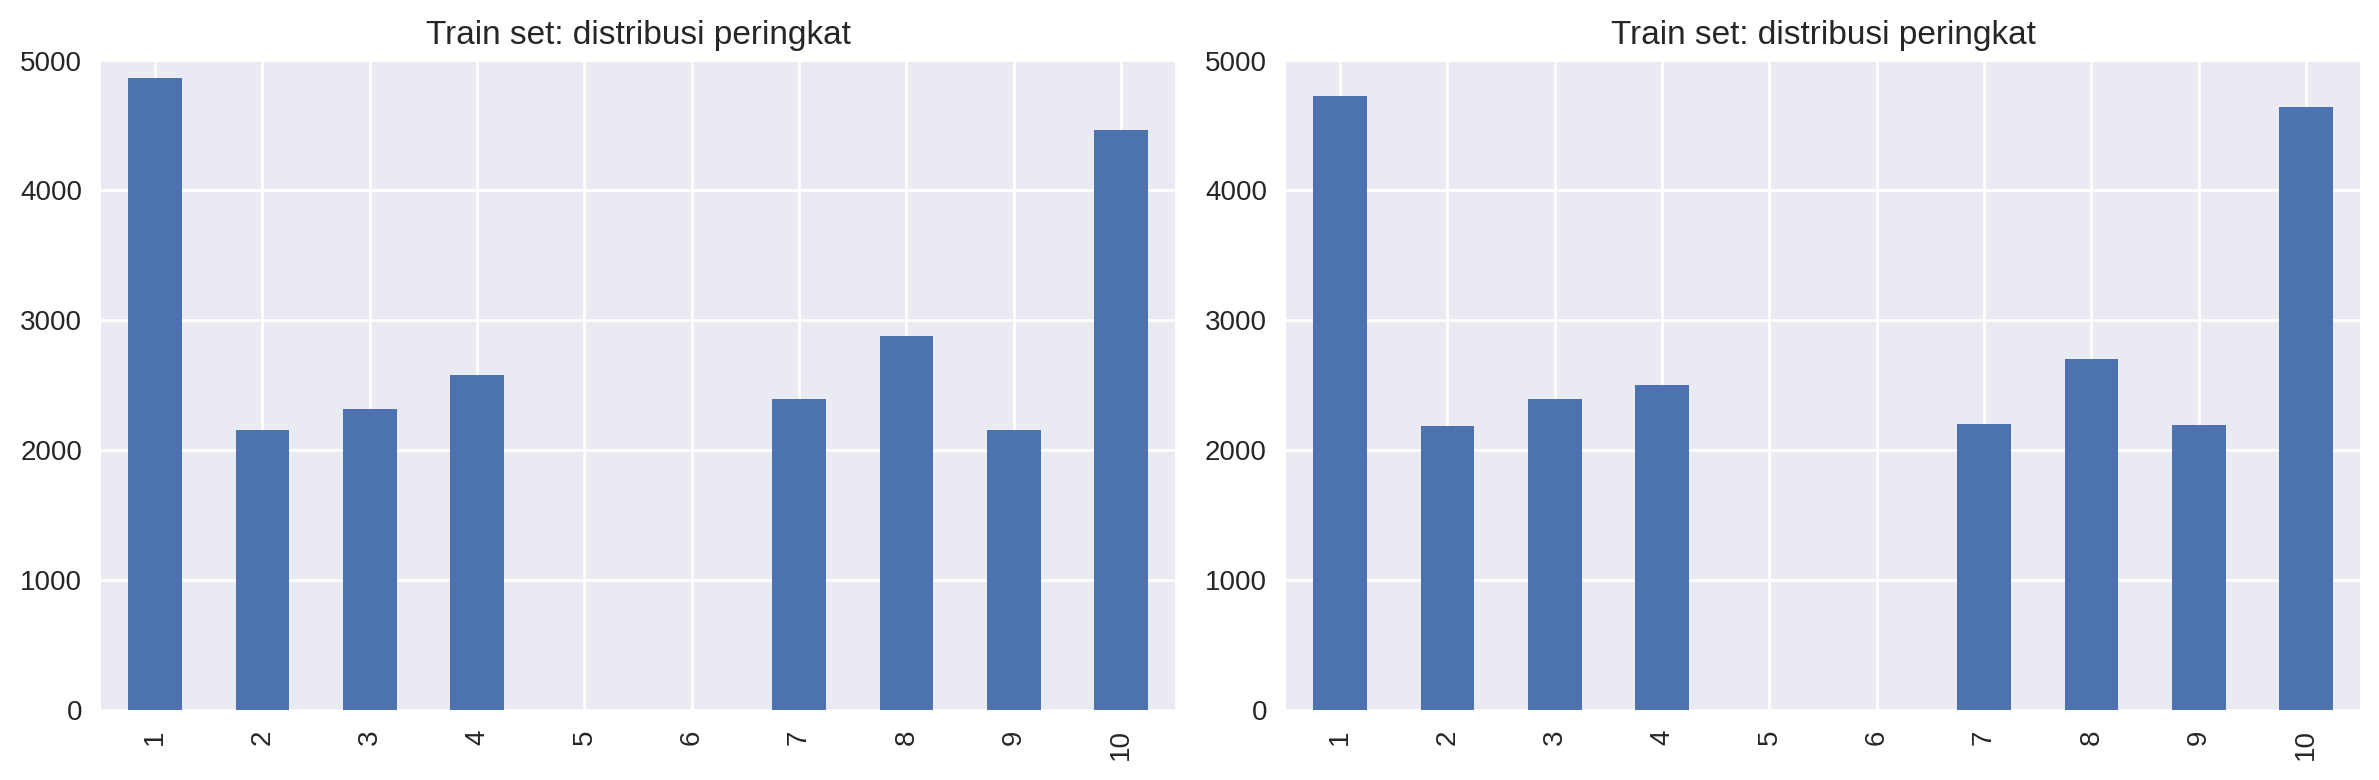

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

Plot peringkat film menunjukkan bahwa film dirangking sangat baik atau sangat buruk dan tidak ada film yang dirangking sedang saja. 

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


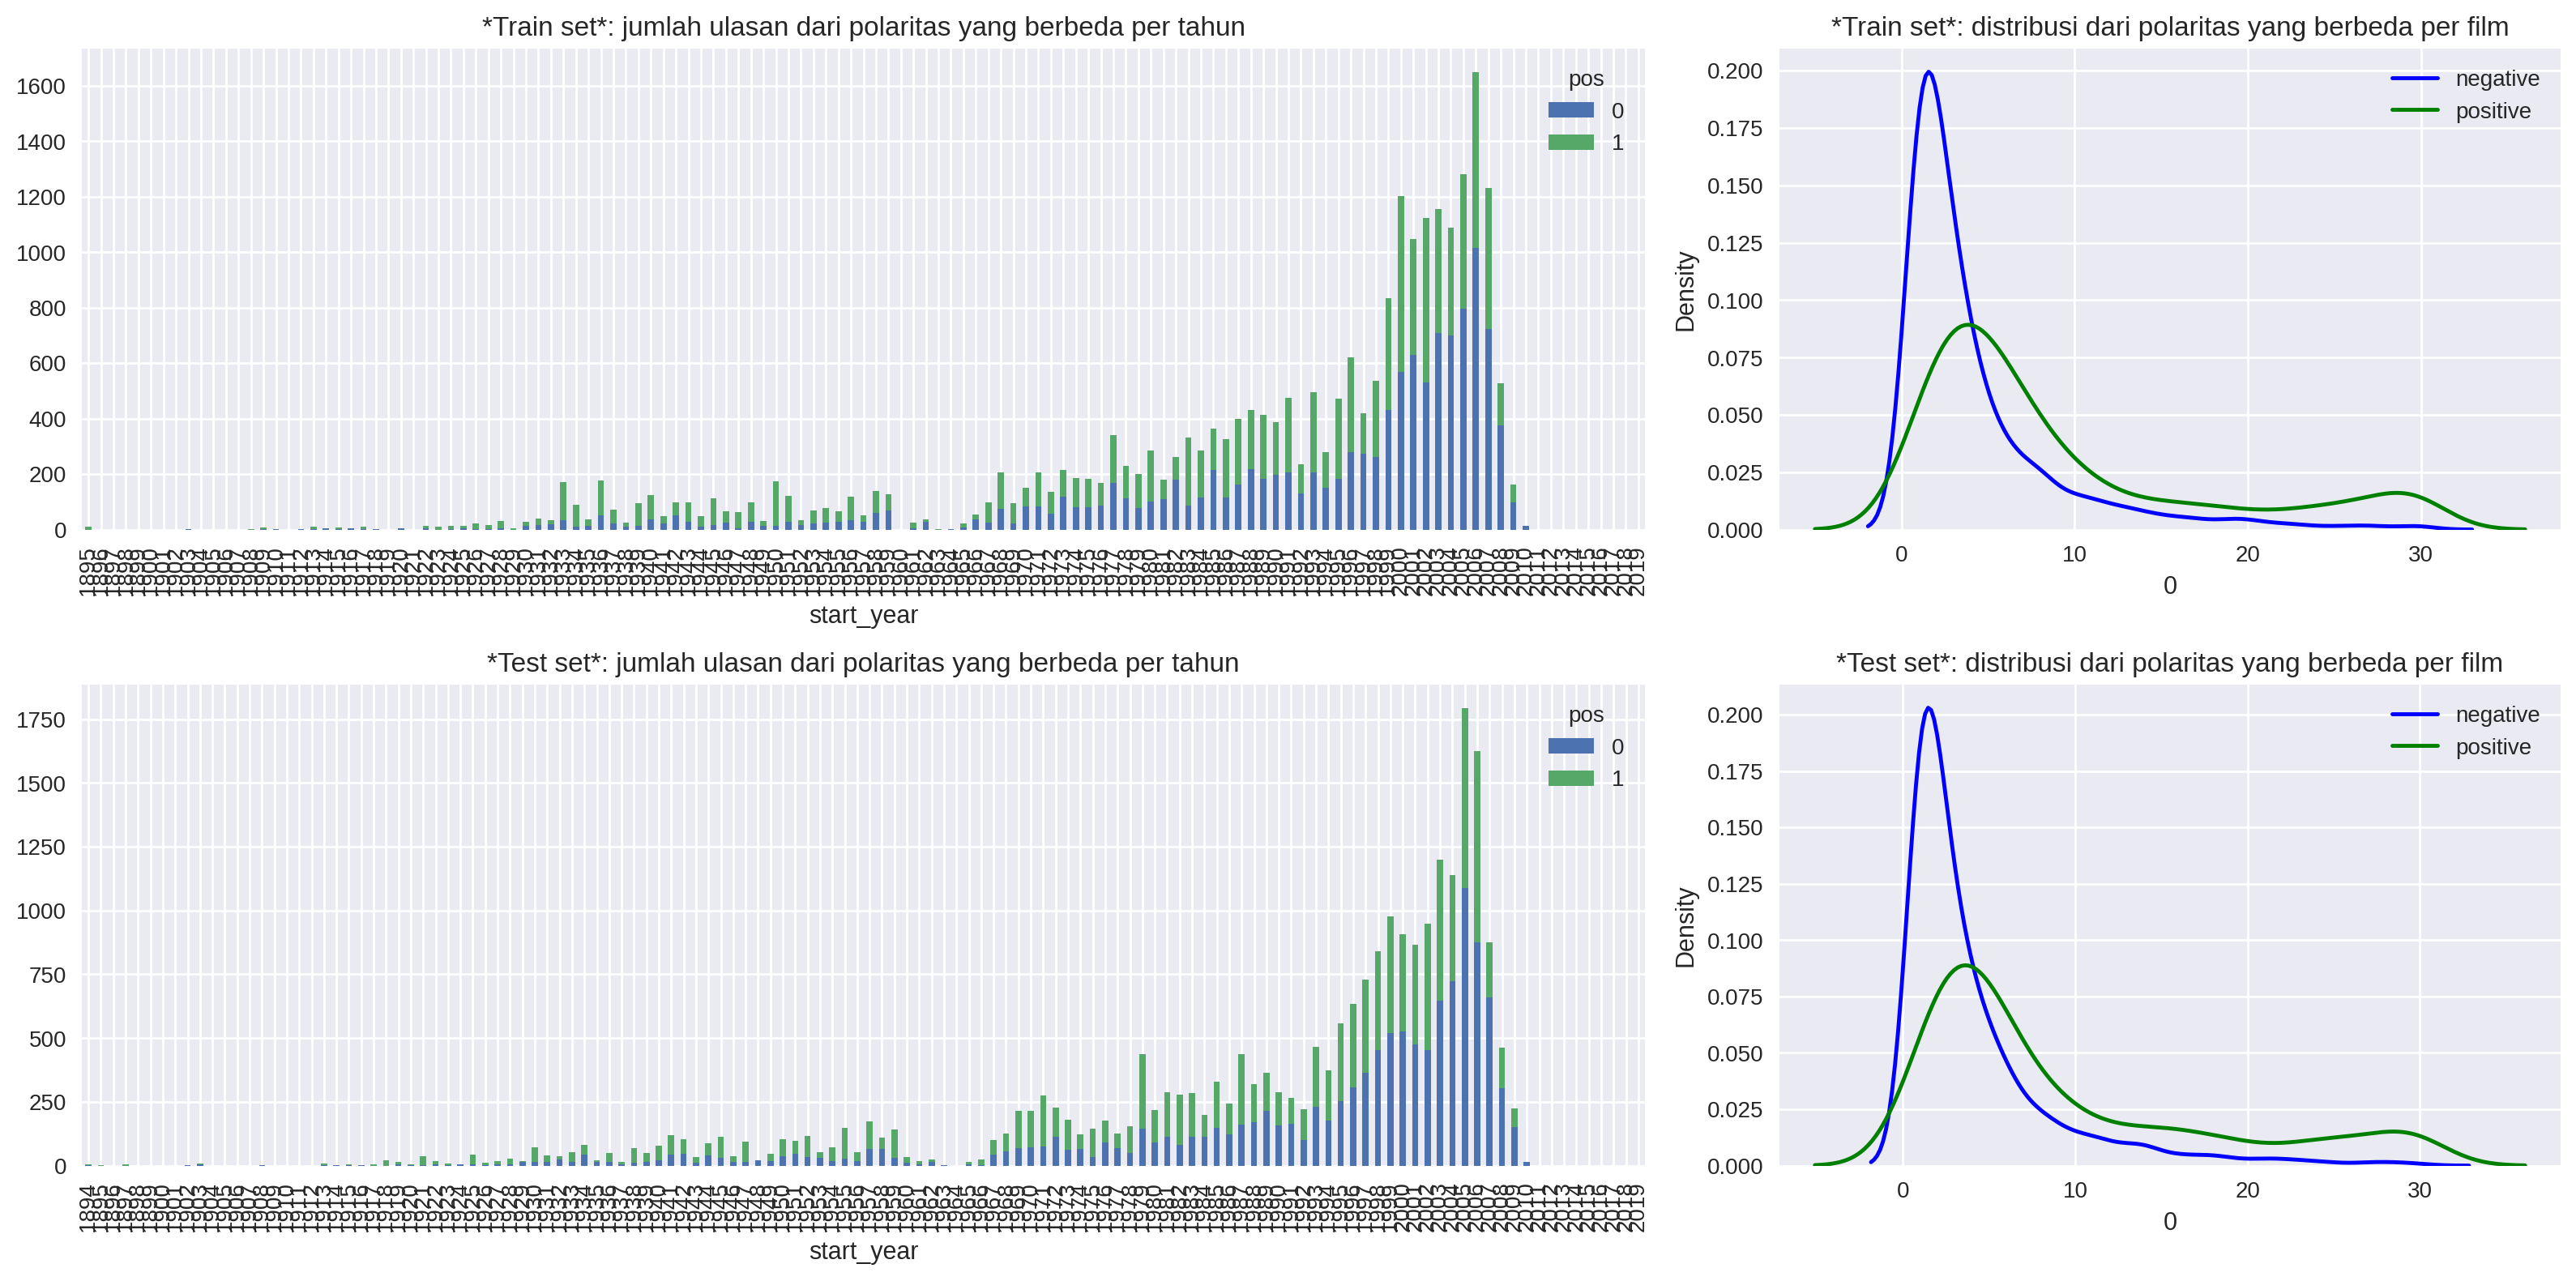

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Train set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Test set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

Perbadingan antara train dan test set menunjukkan bahwa data-data yang dimiliki kedua set tersebut memiliki distribusi yang hampir mirip, sehingga mesin learning kemungkinan dapat memprediksi test set dengan baik. 

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
        model.fit(features, target)
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [14]:
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [16]:
def clear_text(text):
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = clean_text.lower()
    clean_text = " ".join(clean_text.split())
    return clean_text
def lemmatize(text):
    words = nltk.word_tokenize(text)
    filtered_sentence = [w for w in words if not w.lower() in stop_words]
    lemmas = ' '.join(wnl.lemmatize(word) for word in filtered_sentence)
    return lemmas


In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text).apply(lemmatize)

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Bekerja dengan Model

### Model 0 - Konstan

In [19]:
from sklearn.dummy import DummyClassifier


In [20]:
clf = DummyClassifier(strategy= 'stratified')

In [21]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

          train  test
Accuracy    NaN   NaN
F1          0.5  0.49
APS         0.5  0.50
ROC AUC     0.5  0.50


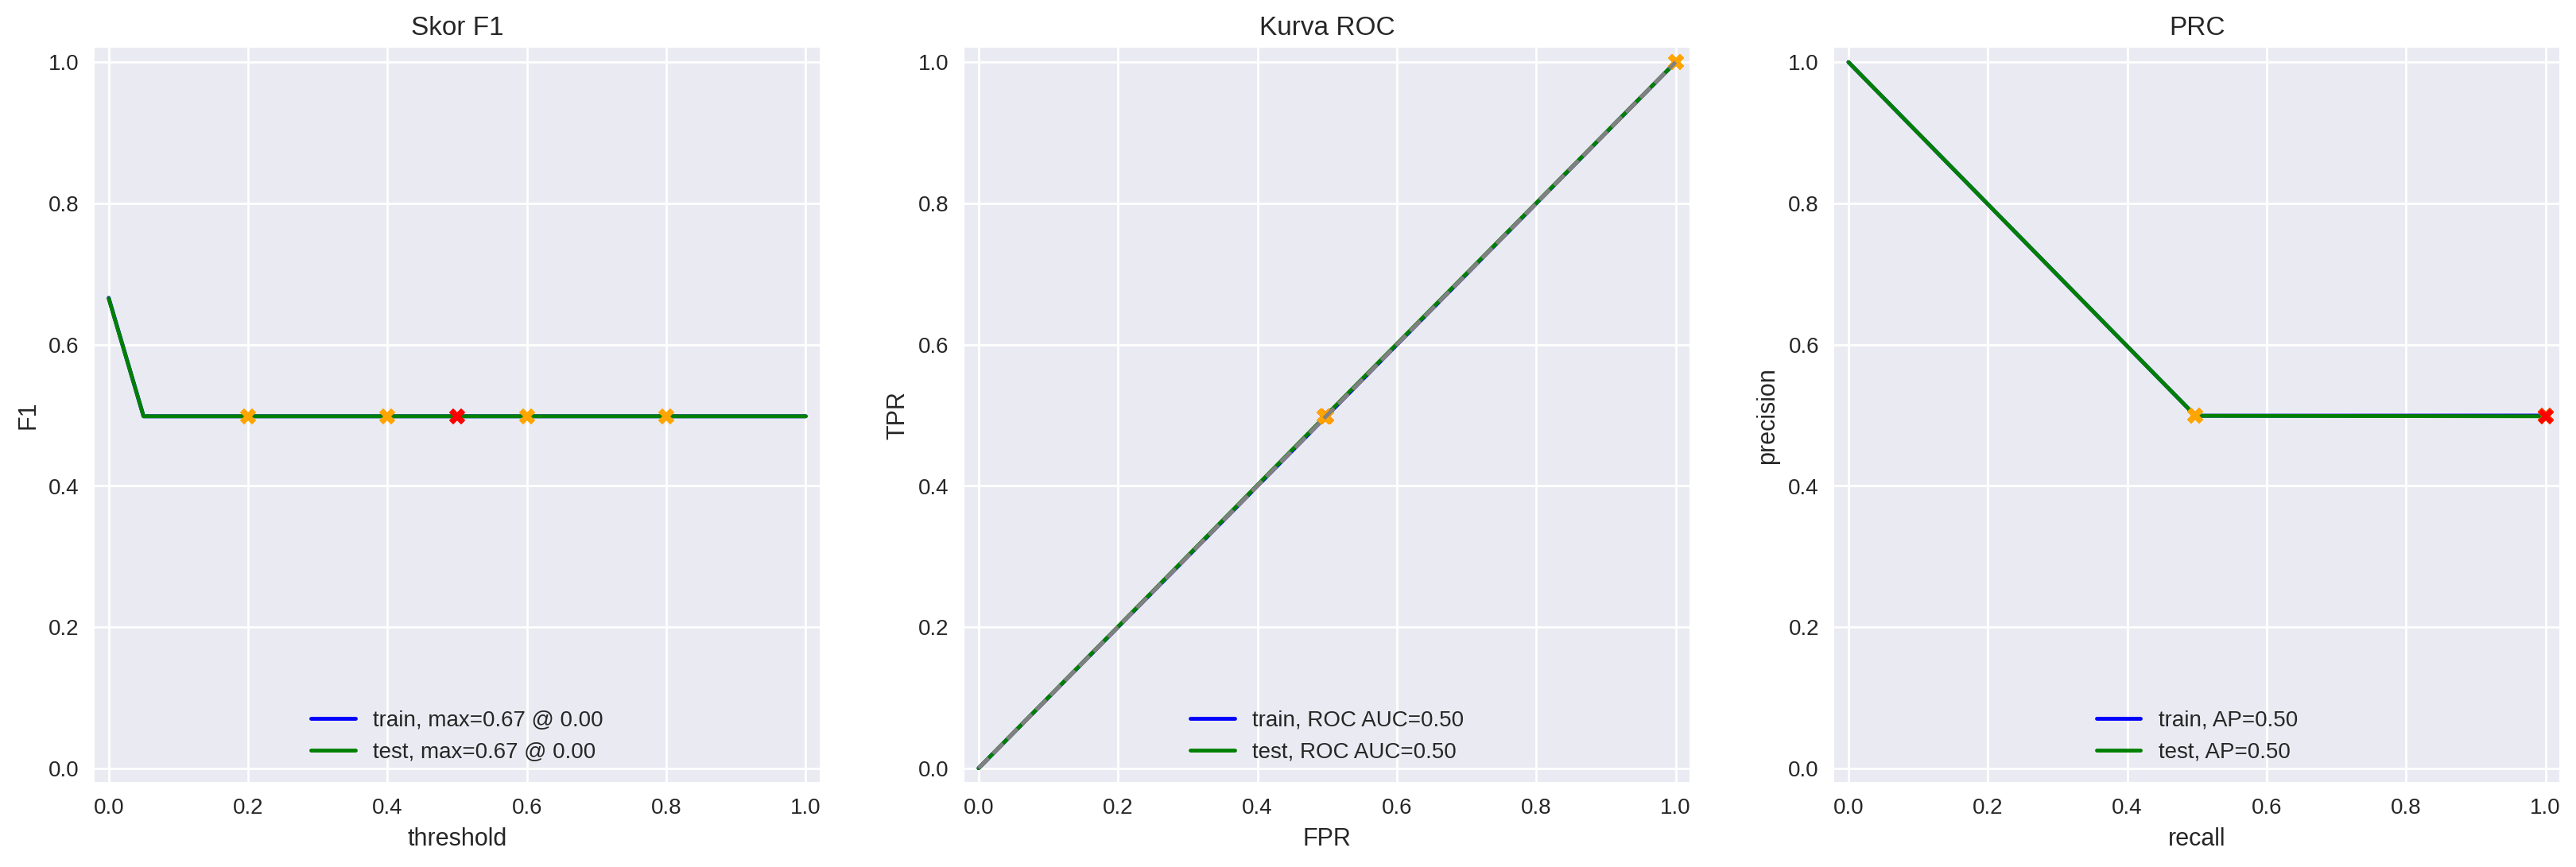

In [22]:
evaluate_model(clf, train_features_0, train_target, test_features_0, test_target)

Dummy model sebagai baseline memiliki perfoma prediksi yang setara dengan prediksi probabilitas kemungkinan. 

### Model 2 - NLTK, TF-IDF dan LR

TF-IDF

In [23]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


In [24]:
train_corpus = df_reviews_train['review_norm']
test_corpus = df_reviews_test['review_norm']

In [25]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words= stop_words)
train_features_2 = tfidf_vectorizer_2.fit_transform(train_corpus)
test_features_2= tfidf_vectorizer_2.fit_transform(test_corpus)

In [26]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.94  0.94
APS        0.98  0.99
ROC AUC    0.98  0.99


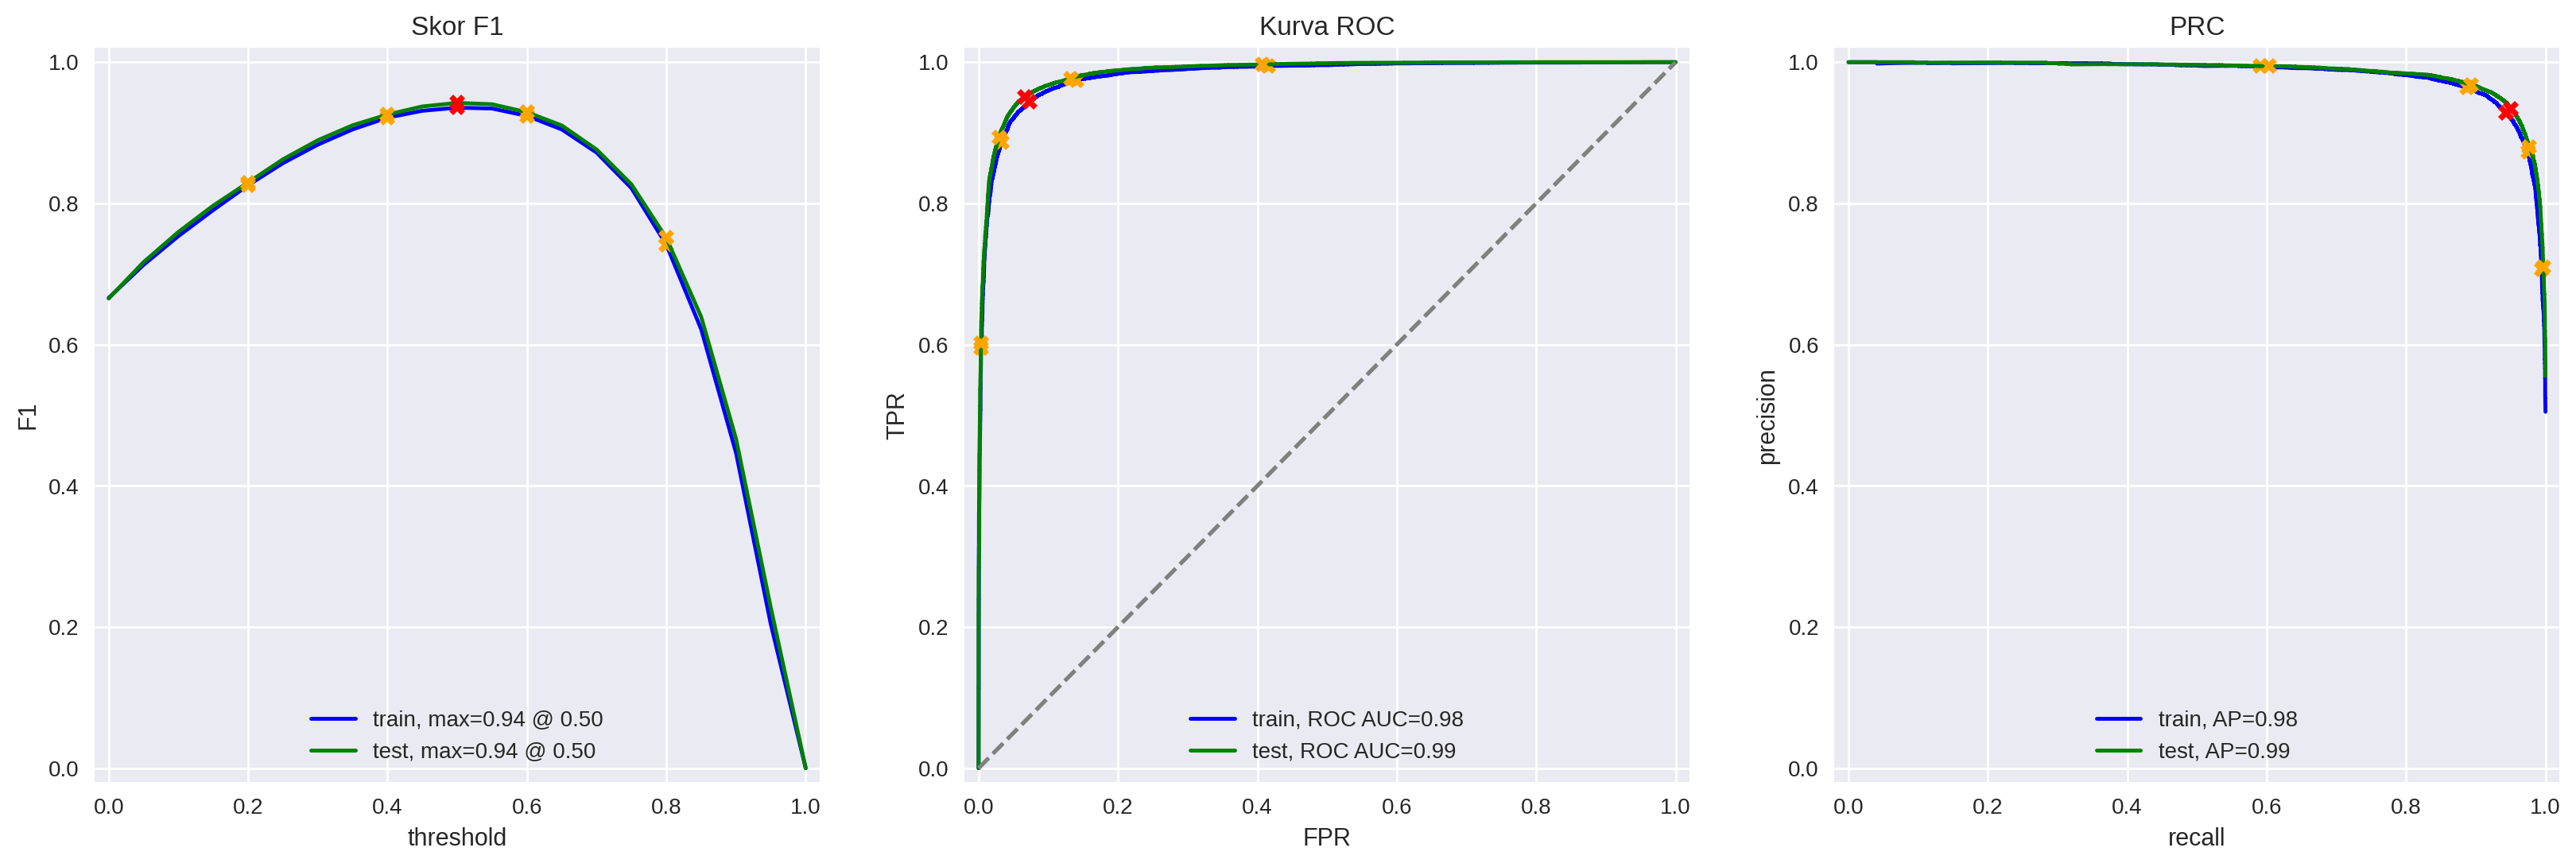

In [27]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Penggunaan model regresi logistik dengan normalisasi review dan pemvektoran kata menunjukkan perfoma prediksi yang signifikan lebih baik dibandingkan dummy model, baik dari segi presisi, akurasi dan kemampuan recalling. 

### Model 3 - spaCy, TF-IDF dan LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
df_reviews_train['review_norm_lemma'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)

In [ ]:
train_corpus_3 = df_reviews_train['review_norm_lemma']
test_corpus_3 = df_reviews_test['review_norm_lemma']

In [ ]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words= stop_words)

In [ ]:
train_features_3 = tfidf_vectorizer_3.fit_transform(train_corpus_3)
test_features_3=tfidf_vectorizer_3.fit_transform(test_corpus_3)

In [ ]:
model_3 = LogisticRegression()
model_3.fit(train_features_3, train_target)

In [ ]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Penggunaan spacy nlp dan pemvektoran kata diikuti prediksi machine learning dengan regresi logistik menunjukkan bahwa performa yang lebih baik dibandingkan model dummy walaupun memiliki perfoma yang sama dengan nltk dalam semua metriks. 

### Model 3 - spaCy, TF-IDF dan LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
model_4 = LGBMClassifier()

In [ ]:
tfidf_vectorizer_4 = TfidfVectorizer(stop_words = stop_words)

In [ ]:
train_features_4 = tfidf_vectorizer_4.fit_transform(train_corpus_3)
test_features_4 = tfidf_vectorizer_4.fit_transform(test_corpus_3)

In [ ]:
model_4.fit(train_features_4, train_target)

In [ ]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

Penggunaan spacy nlp dan pemvektoran kata diikuti prediksi machine learning dengan LGBM classifier menunjukkan bahwa performa yang lebih baik dibandingkan model dummy walaupun memiliki perfoma yang sama dengan nltk dalam semua metriks. 

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    
    # <masukkan kode di sini untuk ids_list dan attention_mask_list>
    for text in texts:

        ids = tokenizer.encode(
            text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
        )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {perangkat} perangkat.')
    
    # dapatkan embedding dalam batch 

    embeddings = []
    

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch 
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])     
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9 = test_features_9)

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [ ]:
model_9= LogisticRegression()

Tahapan ini tidak dapat dilakukan dikarenakan keterbatasan perangkat. 

## Ulasan Saya

In [43]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja 
my_reviews = pd.DataFrame([
    'I do not like it that much, it is not really my type.', 
    'Boring, I even slept in the middle of the movie.', 
    'A very good film, a personal favorite',     
    'Many of the actors look old and not enthusiastic with the movie, are they even paid to act. It is really not worth the time.', 
    'I can not believe the movie would be this good! The writer trully look up every details', 
    'This movie has its own merits and flaws, but generally kind of worthy. I probably would rewatch it.', 
    'Some of the jokes are not even funny. There is no a single good joke, everybody acts so annoyingly, even the children do not like it!', 
    'Releasing this series on Netflix is a bold move and I am quite happy that I can watch episode by episode of this new interesting and brilliant drama.' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text).apply(lemmatize)

my_reviews

,review,review_norm
0,"I do not like it that much, it is not really m...",like much really type
1,"Boring, I even slept in the middle of the movie.",boring even slept middle movie
2,"A very good film, a personal favorite",good film personal favorite
3,Many of the actors look old and not enthusiast...,many actor look old enthusiastic movie even pa...
4,I can not believe the movie would be this good...,believe movie would good writer trully look ev...
5,"This movie has its own merits and flaws, but g...",movie merit flaw generally kind worthy probabl...
6,Some of the jokes are not even funny. There is...,joke even funny single good joke everybody act...
7,Releasing this series on Netflix is a bold mov...,releasing series netflix bold move quite happy...


<div class="alert alert-danger">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

karena model dilatih dengan data berbahasa inggris maka kamu juga harus menguji model dengan data uji berbahasa inggris juga yaa. Untuk itu silahkan di translate dulu ke bahasa inggris

</div>

### Model 2

In [44]:
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.39:  like much really type
0.03:  boring even slept middle movie
0.98:  good film personal favorite
0.17:  many actor look old enthusiastic movie even paid act really worth time
0.28:  believe movie would good writer trully look every detail
0.35:  movie merit flaw generally kind worthy probably would rewatch
0.12:  joke even funny single good joke everybody act annoyingly even child like
0.91:  releasing series netflix bold move quite happy watch episode episode new interesting brilliant drama


### Model 3

In [45]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  like much really type
0.02:  boring even slept middle movie
0.99:  good film personal favorite
0.11:  many actor look old enthusiastic movie even paid act really worth time
0.29:  believe movie would good writer trully look every detail
0.35:  movie merit flaw generally kind worthy probably would rewatch
0.13:  joke even funny single good joke everybody act annoyingly even child like
0.95:  releasing series netflix bold move quite happy watch episode episode new interesting brilliant drama


### Model 4

In [46]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  like much really type
0.19:  boring even slept middle movie
0.90:  good film personal favorite
0.35:  many actor look old enthusiastic movie even paid act really worth time
0.46:  believe movie would good writer trully look every detail
0.35:  movie merit flaw generally kind worthy probably would rewatch
0.67:  joke even funny single good joke everybody act annoyingly even child like
0.89:  releasing series netflix bold move quite happy watch episode episode new interesting brilliant drama


### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)



In [ ]:
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Tahapan ini tidak dapat dilakukan karena keterbatasan perangkat. 

## Kesimpulan

Projek menemukan bahwa sebagian besar film umumnya hanya memiliki satu atau sedikit ulasan dan sebagian besar ulasan memiliki nilai negatif. Film juga umumnya dirangking sangat baik atau sangat buruk dan jarang yang berada pada rangking pertengahan. Untuk melihat pola ulasan dan penilaian film, diperlukan prediksi mesin yang dapat menilai apakah ulasan suatu film memiliki tanggapan yang positif atau negatif. Pengolahan teks yang paling umum adalah dengan menggunakan algoritma NLTK atau Spacy.nlp untuk proses pembakuan kata agar hubungan antar kata dapat lebih jelas, diikuti dengan pemvektoran kepentingan kata menggunakan algritma Tf/IDF atau BERT, meskipun BERT tidak dapat dilakukan pada projek ini disebabkan keterbatasan perangkat. Prediksi apakah ulasan menanggapi secara positif atau negatif menggunakan pembelajaran klasifikasi. Algroritma Regresi Logistik maupun LGBM tidak menunjukkan performa prediksi yang berbeda setelah teks diolah menggunakan pemvektoran. Sehingga dapat disimpulkan bahwa pengolahan menggunakan NLTK atau Spacy diikuti TF IDF vektorizer memiliki performa yang sama, meskipun algoritma regresi logistik lebih disarankan karena kecepatanya. 